In [1]:
%run train.py

/home/emon/anaconda3/envs/torchpy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from config import args
from model import UNet3D
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
import time
from tqdm import tqdm
import torch.nn.functional as F

In [3]:
torch.manual_seed(args.seed)
model = UNet3D(in_channels=args.in_channel, out_channels=args.output_channel).to(args.device)

In [4]:
G_net = UNet3D(in_channels=args.in_channel, out_channels=args.output_channel).to(args.device)

In [5]:
def f1(probability, targets):
    probability = probability.flatten()
    targets = targets.flatten()
    assert (probability.shape == targets.shape)

    intersection = 2.0 * (probability * targets).sum()
    union = (probability * probability).sum() + (targets * targets).sum()
    dice_score = intersection / union
    return 1.0 - dice_score

In [6]:
G_net.train()

UNet3D(
  (contracting_layers): ModuleList(
    (0): ModuleList(
      (0): Conv3d(4, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ModuleList(
      (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, 

In [7]:
G_loss_fun = f1

In [8]:
# copy weights
w_glob = G_net.state_dict()

In [9]:
# client number 
m = max(args.num_C, 1)

In [10]:
import numpy as np
def get_dataset(args, verbose=True):
    train_dataset = BraTS20Dataset(
        set_dir=hp["training_dir"],
        data_dir=hp["data_dir_name"],
        seg_dir=hp["seg_dir_name"])
    val_dataset = BraTS20Dataset(
        set_dir=hp["validation_dir"],
        data_dir=hp["data_dir_name"],
        seg_dir=hp["seg_dir_name"])


    data_idcs = np.arange(len(train_dataset))
    clients_split = []
    length= int(len(train_dataset)/args.num_C) if args.data_length == 0 else args.data_length

    data = [train_dataset[data_idcs[j]] for j in range (length)]
    print(len(data_idcs))
    for i in range(args.num_C):
        np.random.shuffle(data_idcs)
        print(data_idcs)
        data = [train_dataset[data_idcs[j]] for j in range (length)]
        clients_split += [data]
    client_loaders = [torch.utils.data.DataLoader(x, batch_size=args.batch_size, shuffle=True) for x in clients_split]
    
    
    
    data_idcs = np.arange(len(val_dataset))
    clients_split = []
    length= int(len(val_dataset)/args.num_C) if args.data_length == 0 else args.data_length
    data = [val_dataset[data_idcs[j]] for j in range (length)]
    print(len(data_idcs))
    for i in range(1):
        np.random.shuffle(data_idcs)
        print(data_idcs)
        data = [val_dataset[data_idcs[j]] for j in range (length)]
        clients_split += [data]
    test_loaders = [torch.utils.data.DataLoader(x, batch_size=args.batch_size, shuffle=True) for x in clients_split]
    test_loaders = test_loaders[0]
    return client_loaders, test_loaders

In [11]:
from brats20_dataset import BraTS20Dataset
from load_hyperparameters import hp
C_iter, test_iter = get_dataset(args)
print(len(C_iter[0]))

4644
[ 197  963 2191 ... 1346 2804  514]
[1787 2965 3797 ...  381 1717 2824]
[4311 3734  734 ... 1174  165 2842]
[2762 2063 3930 ... 3329 3690  851]
[4445  248  336 ... 1068 3987 1327]
1998
[813  40 947 ... 258 965 109]
50


In [12]:
def quantize(kernel, w_p, args):
    """
    :return quantized weights of a certain layer, which is: w_p * [1, 0, -1].
    """
    prob = np.random.rand()
    if prob > 0.5:
        T_k = args.T_thresh + 0.01 * prob
    else:
        T_k = args.T_thresh + 0.01 * 0.5

    if args.ada_thresh is False:
        delta = T_k * kernel.abs().max()
    else:
        T_a = 0.07
        d2 = kernel.size(0) * kernel.size(1)
        delta = T_a * kernel.abs().sum() / d2

        tmp1 = (kernel.abs() > delta).sum()
        tmp2 = ((kernel.abs() > delta)*kernel.abs()).sum()
        w_p = tmp2 / tmp1


    a = (kernel > delta).float()
    b = (kernel < -delta).float()

In [13]:
def onehot_initialization_v2(a, ncols=4):
    out = torch.zeros(a.numel(), ncols)
    out[torch.arange(a.numel()), a.ravel()] = 1
    return out.to(device=args.device)

In [14]:
def get_grads(kernel_grad, kernel, w_p, args):
    """
    Arguments:
        kernel_grad: gradient with respect to quantized kernel.
        kernel: corresponding full precision kernel.
        w_p: quantization factor.
        args: arguments
    Returns:
        1. gradient for the full precision kernel.
        2. gradient for w_p.
    """
    T_k = args.T_thresh

    delta = T_k * kernel.abs().max()

    # masks
    a = (kernel > delta).float().to(args.device)
    b = (kernel < -delta).float().to(args.device)

    c = torch.ones(kernel.size()).to(args.device) - a - b

    return w_p*a*kernel_grad + w_p*b*kernel_grad + 1.0*c*kernel_grad, (a*kernel_grad).sum()

In [15]:
def optimization_step(model, loss, x_batch, y_batch, current_round, optimizer_list, args):
    """Make forward pass and update model parameters with gradients."""

    total_epoch = current_round*args.local_e

    optimizer, optimizer_fp, optimizer_sf = optimizer_list



    x_batch = x_batch.to(args.device)
    y_batch = y_batch.to(args.device)
    logits = model(x_batch)
    
    seg = onehot_initialization_v2(torch.flatten(y_batch))
    
    seg = torch.reshape(seg, (1, 64, 64, 64, hp["num_classes"]))
    seg = torch.moveaxis(seg, 4, 1)
    
    # print('lshape', logits.shape)
    # print('lshape', seg.shape)
    loss_value = loss(logits, seg)
    batch_loss = loss_value.item()

    # pred = seg

    optimizer.zero_grad()
    optimizer_fp.zero_grad()
    optimizer_sf.zero_grad()
    loss_value.backward()

    all_kernels = optimizer.param_groups[0]['params']
    all_fp_kernels = optimizer_fp.param_groups[0]['params']
    scaling_factors = optimizer_sf.param_groups[0]['params']

    wp_lists = [0 for i in range(len(all_kernels))]

    for i in range(len(all_kernels)):
        k = all_kernels[i]
        k_fp = all_fp_kernels[i]
        f = scaling_factors[i]
        w_p = f.data
        k_fp_grad, w_p_grad = get_grads(k.grad.data, k_fp.data, w_p, args)
        k_fp.grad = k_fp_grad
        k.grad.data.zero_()
        f.grad = w_p_grad.to(args.device)



    optimizer.step()
    # update all full precision kernels
    optimizer_fp.step()
    # update all scaling factors
    optimizer_sf.step()


    for i in range(len(all_kernels)):
        k = all_kernels[i]
        k_fp = all_fp_kernels[i]
        f = scaling_factors[i]
        w_p = f.data
        # re-quantize a quantized kernel using updated full precision weights
        # k.data = quantize(k_fp.data, w_p, args)

        wp_lists[i] = f.clone()

    return wp_lists

In [16]:
def accuracy(true, pred, top_k=(1,)):
    correct_pixels = 0
    total_pixels = 0
    correct_pixels += (pred == true).sum()
    total_pixels += torch.numel(pred)
    return (correct_pixels / total_pixels).item()
def evaluate(model, loss, val_iterator, args):
    model.eval()
    model = model.to(args.device)
    loss_value = 0.0
    acc = 0.0
    top5_acc = 0.0
    total_samples = 0

    with torch.no_grad():
        for x_batch, y_batch in val_iterator:
            x_batch = x_batch.to(args.device)
            y_batch = y_batch.to(args.device)
            n_batch_samples = y_batch.size()[0]
            logits = model(x_batch)
            # print('log shape', logits.shape)
            # print('batch shape', y_batch.shape)
            
            seg = onehot_initialization_v2(torch.flatten(y_batch))
            seg = torch.reshape(seg, (1, 64, 64, 64, hp["num_classes"]))
            seg = torch.moveaxis(seg, 4, 1)
            
            # print('log shape', logits.shape)
            # print('batch shape', seg.shape)

            # compute logloss
            batch_loss = loss(logits, seg).item()

            # compute accuracies
            pred = torch.argmax(logits, dim=1)
            # print(y_batch)
            # print(pred)
            batch_acc = accuracy(y_batch, pred, top_k=(1, 5))

            loss_value += batch_loss * n_batch_samples
            acc += batch_acc * n_batch_samples
            # top5_acc += batch_top5_acc * n_batch_samples
            total_samples += n_batch_samples

    return loss_value/total_samples, acc/total_samples

In [17]:
def quantize_train(model, loss, optimization_step_fn, train_iterator, val_iterator, client_name, args):
    """
    Train 'model' by minimizing 'loss' using 'optimization_step_fn'
    for parameter updates.
    """
    # collect losses and accuracies here
    all_losses = []
    start_time = time.time()
    model.train()
    acc = []
    wp_lists = []
    record_list = np.zeros((100, 5))
    for epoch in range(0, args.local_e):

        # main training loop
        for ind, (x_batch, y_batch) in enumerate(train_iterator):
            wp_lists = optimization_step_fn(model, loss, x_batch, y_batch, args)

    end_time = time.time()
    test_loss, test_acc = evaluate(model, loss, val_iterator, args)

    all_losses += [(
        client_name,
        test_loss,
        test_acc
    )]
    acc.append(test_acc*100)

    out_str = 'Client:{0: d}, test loss:{1:.3f}, ' + \
              'test acc:{2:.3f}, ' 
    print(out_str.format(*all_losses[-1]))

    return model.state_dict(), wp_lists

In [18]:
def initial_scales():
    """
    :return: initialized quantization factor w_p
    """
    return 1.0
def fed_quan(pre_model, train_iter, test_iter, client_name, current_round, scale_factors, args):

    # model setup
    model = UNet3D(in_channels=args.in_channel, out_channels=args.output_channel).to(args.device)
    loss_fun = f1
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    # model.to(args.device)

    model.train()
    # copy almost all full precision kernels of the model
    all_fp_kernels = [
        kernel.clone().detach().requires_grad_(True)
        for kernel in optimizer.param_groups[0]['params']]

    # init quantification
    initial_scaling_factors = []

    all_kernels = [kernel for kernel in optimizer.param_groups[0]['params']]

    ii = 0
    for k, k_fp in zip(all_kernels, all_fp_kernels):

        w_p_initial = initial_scales()

        initial_scaling_factors += [w_p_initial]
        # quantization
        # print(w_p_initial)
        # k.data = quantize(k_fp.data, w_p_initial, args)
        ii += 1



    # optimizer for updating only all_fp_kernels
    optimizer_fp = optim.Adam(all_fp_kernels, lr=args.lr)

    # optimizer for updating only scaling factors
    optimizer_sf = optim.Adam([
        torch.tensor(w_p).to(args.device).requires_grad_(True)
        for w_p in initial_scaling_factors
    ], lr=args.lr)


    optimizer_list = [optimizer, optimizer_fp, optimizer_sf]

    def optimization_step_fn(p_model, loss_f, x_batch, y_batch, arg):
        return optimization_step(p_model, loss_f, x_batch, y_batch, current_round,
                                 optimizer_list, arg)

    model_dict, wp_lists = ternary_train(model, loss_fun, optimization_step_fn, train_iter, test_iter, client_name, args)

    return model_dict, wp_lists

In [19]:
class LocalUpdate(object):
    def __init__(self, client_name, c_round, train_iter, test_iter, wp_lists, args):
        self.c_name = client_name
        self.c_round = c_round
        self.wp_lists = wp_lists
        self.args = args
        self.local_train = train_iter
        self.local_test = test_iter
        self.loss_func = f1

    def TFed_train(self, net):
        # train and update
        net_dict, wp_lists = fed_ttq(net, self.local_train, self.local_test, self.c_name, self.c_round, self.wp_lists, self.args)

        return net_dict, wp_lists

In [20]:
w_locals = []
c_lists = [[] for i in range(args.num_C)]
print(C_iter[0])

In [21]:
def ServerUpdate(w, num_samp):
    '''
    :param w: all participating weights, list
    :param num_samp: number of data on each client, np.array
    :return:
    '''

    num_samp = np.array(num_samp)
    frac_c = num_samp / num_samp.sum()
    num_model = len(w)
    w_avg = w[0]
    for key, value in w_avg.items():
        for i in range(0, num_model):
            if i == 0:
                w_avg[key] = frac_c[0] * w[0][key]
            else:
                w_avg[key] += frac_c[i] * w[i][key]

    backup_w = copy.deepcopy(w_avg)

    return w_avg

In [22]:
for rounds in range(50):
    w_locals = []
    client_id = range(args.num_C)
    print('Round {:d} start'.format(rounds, client_id))
    num_samp = []
    for idx in range(args.num_C):
        # print(idx)
        local = LocalUpdate(client_name = idx, c_round = rounds, train_iter = C_iter[idx], test_iter = test_iter, wp_lists= c_lists[idx], args=args)
        w, wp_lists = local.TFed_train(net=copy.deepcopy(G_net).to(args.device))
        c_lists[idx] = wp_lists
        w_locals.append(copy.deepcopy(w))

        num_samp.append(len(C_iter[idx].dataset))
    w_glob = ServerUpdate(w_locals, num_samp)
    G_net.load_state_dict(w_glob)
    g_loss, g_acc = evaluate(G_net, G_loss_fun, test_iter, args)
    print('Round {:3d}, Global loss {:.3f}, Global Acc {:.3f}'.format(rounds, g_loss, g_acc))

Round 0 start
Client: 0, test loss:0.481, test acc:0.235, 
Client: 1, test loss:0.539, test acc:0.035, 
Client: 2, test loss:0.542, test acc:0.043, 
Client: 3, test loss:0.456, test acc:0.790, 
Client: 4, test loss:0.527, test acc:0.035, 
Round   0, Global loss 0.502, Global Acc 0.005
Round 1 start
Client: 0, test loss:0.513, test acc:0.122, 
Client: 1, test loss:0.499, test acc:0.261, 
Client: 2, test loss:0.539, test acc:0.066, 
Client: 3, test loss:0.482, test acc:0.693, 
Client: 4, test loss:0.489, test acc:0.298, 
Round   1, Global loss 0.509, Global Acc 0.001
Round 2 start
Client: 0, test loss:0.504, test acc:0.115, 
Client: 1, test loss:0.425, test acc:0.686, 
Client: 2, test loss:0.562, test acc:0.007, 
Client: 3, test loss:0.483, test acc:0.713, 
Client: 4, test loss:0.487, test acc:0.688, 
Round   2, Global loss 0.490, Global Acc 0.993
Round 3 start
Client: 0, test loss:0.507, test acc:0.050, 
Client: 1, test loss:0.530, test acc:0.059, 
Client: 2, test loss:0.447, test acc:0

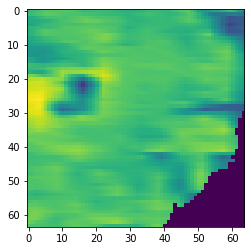

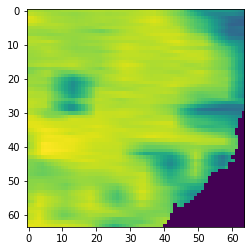

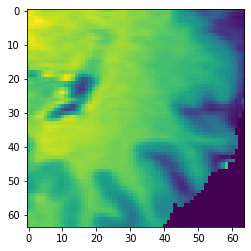

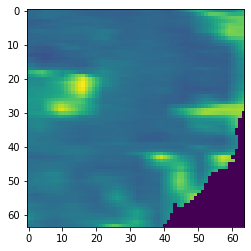

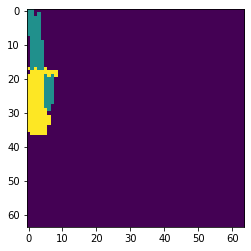

In [27]:
test_iter_enu = enumerate(test_iter)
x_batch, y_batch = test_iter_enu.__next__()
logits = model(x_batch)
pred = torch.argmax(logits, dim=1)
plt.imshow(x_batch[0][0][10].cpu().numpy())
plt.show()
plt.imshow(x_batch[0][1][10].cpu().numpy())
plt.show()
plt.imshow(x_batch[0][2][10].cpu().numpy())
plt.show()
plt.imshow(x_batch[0][3][10].cpu().numpy())
plt.imshow(pred[1][10].cpu().numpy())
plt.show()

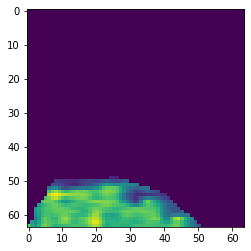

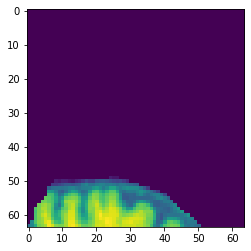

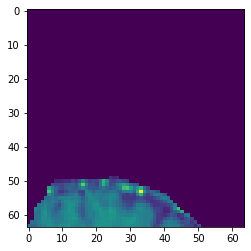

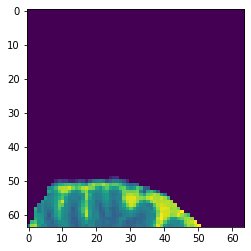

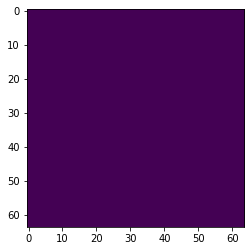

In [29]:
x_batch, y_batch = test_iter_enu.__next__()
logits = model(x_batch)
pred = torch.argmax(logits, dim=1)
plt.imshow(x_batch[0][0][10].cpu().numpy())
plt.show()
plt.imshow(x_batch[0][1][10].cpu().numpy())
plt.show()
plt.imshow(x_batch[0][2][10].cpu().numpy())
plt.show()
plt.imshow(x_batch[0][3][10].cpu().numpy())
plt.imshow(pred[1][10].cpu().numpy())
plt.show()